## Agent Supervisor

The [previous example](multi-agent-collaboration.ipynb) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an LLM to orchestrate the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

![diagram](./img/supervisor-diagram.png)

To simplify the code in each agent node, we will use the AgentExecutor class from LangChain. This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

Before we build, let's configure our environment:

In [1]:
// Deno.env.set("OPENAI_API_KEY", "sk_...");
// Deno.env.set("TAVILY_API_KEY", "sk_...");

// Optional, add tracing in LangSmith
// Deno.env.set("LANGCHAIN_API_KEY", "sk_...");
Deno.env.set("LANGCHAIN_TRACING_V2", "true");
Deno.env.set("LANGCHAIN_PROJECT", "Multi-agent Collaboration: LangGraphJS");

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [1]:
import { TavilySearchResults } from "@langchain/community/tools/tavily_search"
import { DynamicStructuredTool } from "@langchain/core/tools";
import * as d3 from "d3";
import { createCanvas } from "https://deno.land/x/skia_canvas/mod.ts";
import { z } from "zod";

const chartTool = new DynamicStructuredTool({
  name: "generate_bar_chart",
  description:
    "Generates a bar chart from an array of data points using D3.js and displays it for the user.",
  schema: z.object({
    data: z
      .object({
        label: z.string(),
        value: z.number(),
      })
      .array(),
  }),
  func: async ({data}) => {
    // const data = input.data;
    const width = 500;
    const height = 500;
    const margin = { top: 20, right: 30, bottom: 30, left: 40 };

    const canvas = createCanvas(width, height);
    const ctx = canvas.getContext("2d");

    const x = d3
      .scaleBand()
      .domain(data.map((d) => d.label))
      .range([margin.left, width - margin.right])
      .padding(0.1);

    const y = d3
      .scaleLinear()
      .domain([0, d3.max(data, (d) => d.value)])
      .nice()
      .range([height - margin.bottom, margin.top]);

    const colorPalette = [
      "#e6194B",
      "#3cb44b",
      "#ffe119",
      "#4363d8",
      "#f58231",
      "#911eb4",
      "#42d4f4",
      "#f032e6",
      "#bfef45",
      "#fabebe",
    ];

    data.forEach((d, idx) => {
      ctx.fillStyle = colorPalette[idx % colorPalette.length];
      ctx.fillRect(
        x(d.label),
         y(d.value),
        x.bandwidth(),
        height - margin.bottom - y(d.value),
      );
    });

    ctx.beginPath();
    ctx.strokeStyle = "black";
    ctx.moveTo(margin.left, height - margin.bottom);
    ctx.lineTo(width - margin.right, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "center";
    ctx.textBaseline = "top";
    x.domain().forEach((d) => {
      const xCoord = x(d) + x.bandwidth() / 2;
      ctx.fillText(d, xCoord, height - margin.bottom + 6);
    });

    ctx.beginPath();
    ctx.moveTo(margin.left, height - margin.top);
    ctx.lineTo(margin.left, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "right";
    ctx.textBaseline = "middle";
    const ticks = y.ticks();
    ticks.forEach((d) => {
      const yCoord = y(d); // height - margin.bottom - y(d);
      ctx.moveTo(margin.left, yCoord);
      ctx.lineTo(margin.left - 6, yCoord);
      ctx.stroke();
      ctx.fillText(d, margin.left - 8, yCoord);
    });

    await Deno.jupyter.display(canvas);
    return "Chart generated";
  },
});

const tavilyTool = new TavilySearchResults();

## Helper Utilites

Define a helper function below, which make it easier to add new agent worker nodes.

In [2]:
import { AgentExecutor, createOpenAIToolsAgent } from "langchain/agents";
import { HumanMessage } from "@langchain/core/messages";
import { ChatPromptTemplate, MessagesPlaceholder } from "@langchain/core/prompts";
import { ChatOpenAI } from "@langchain/openai";
import { Runnable, type RunnableConfig } from "@langchain/core/runnables";


async function createAgent(
  llm: ChatOpenAI, 
  tools: any[], 
  systemPrompt: string
): Runnable {
  // Each worker node will be given a name and some tools.
  const prompt = await ChatPromptTemplate.fromMessages([
   ["system", systemPrompt],
    new MessagesPlaceholder("messages"),
    new MessagesPlaceholder("agent_scratchpad"),
  ]);
  const agent = await createOpenAIToolsAgent({ llm, tools, prompt });
  return new AgentExecutor({agent, tools});
}


async function agentNode({state, agent, name}, config?: RunnableConfig) {
  const result = await agent.invoke(state, config);
  return {
    messages: [
      new HumanMessage({ content: result.output, name })
    ]
  };
}

## Create Agent Supervisor

The supervisor routes the work between our worker agents.

In [3]:
import { ChatPromptTemplate, MessagesPlaceholder } from "@langchain/core/prompts";
import { ChatOpenAI } from "@langchain/openai";
import { JsonOutputToolsParser } from "langchain/output_parsers";

const members = ["Researcher", "ChartGenerator"];

const systemPrompt = (
  "You are a supervisor tasked with managing a conversation between the" +
  " following workers: {members}. Given the following user request," +
  " respond with the worker to act next. Each worker will perform a" +
  " task and respond with their results and status. When finished," +
  " respond with FINISH."
);
const options = ["FINISH", ...members];

// Define the routing function
const functionDef = {
  name: "route",
  description: "Select the next role.",
  parameters: {
    title: "routeSchema",
    type: "object",
    properties: {
      next: {
        title: "Next",
        anyOf: [
          { enum: options },
        ],
      },
    },
    required: ["next"],
  },
};
const toolDef = {
    type: "function",
    function: functionDef,
}

const prompt = await ChatPromptTemplate.fromMessages([
  ["system", systemPrompt],
  new MessagesPlaceholder("messages"),
  [
    "system",
    "Given the conversation above, who should act next?"
      +" Or should we FINISH? Select one of: {options}",
  ],
]).partial({ options: options.join(", "), members: members.join(", ") });

const llm = new ChatOpenAI("gpt-4-1106-preview");

const supervisorChain = prompt
  .pipe(llm.bind({tools: [toolDef], tool_choice: {"type": "function", "function": {"name": "route"}}}))
  .pipe(new JsonOutputToolsParser())
   // select the first one
  .pipe((x ) => (x[0].args));


In [4]:
await supervisorChain.invoke({
  messages: [
    new HumanMessage({
      content:"write a report on birds."
    })
  ]
});

{ next: "Researcher" }

## Construct Graph

We're ready to start building the graph. First, we'll define the state the graph will track.

In [5]:
import { BaseMessage } from "@langchain/core/messages";

interface AgentStateChannels {
  messages: {
    value: (x: BaseMessage[], y: BaseMessage[]) => BaseMessage[];
    default: () => BaseMessage[];
  };
  next: string;
}

// This defines the agent state
const agentStateChannels: AgentStateChannels = {
  messages: {
    value: (x: BaseMessage[], y: BaseMessage[]) => x.concat(y),
    default: () => [],
  },
  next: 'initialValueForNext', // Replace 'initialValueForNext' with your initial value if needed
};


Next, create the agents to add to the graph.

In [6]:
const llm = new ChatOpenAI({modelName: "gpt-4-1106-preview"});

const researcherAgent = await createAgent(
  llm, 
  [tavilyTool], 
  "You are a web researcher. You may use the Tavily search engine to search the web for"
    +" important information, so the Chart Generator in your team can make useful plots."
);
const researcherNode = async (state, config) => await agentNode({
  state, 
  agent: researcherAgent, 
  name: "Researcher",
  config
});
const chartGenAgent = await createAgent(
  llm, 
  [chartTool], 
  "You excel at generating bar charts. Use the researcher's information to generate the charts."
);
const chartGenNode = async (state, config) => await agentNode({
  state, agent: chartGenAgent, 
  name: "ChartGenerator",
})

Now we can create the graph itself! Add the nodes, and add edges to define how how work will be performed in the graph.

In [9]:
import { StateGraph, END } from "@langchain/langgraph";

// 1. Create the graph
const workflow = new StateGraph({
  channels: agentStateChannels,
});

// 2. Add the nodes; these will do the work
workflow.addNode("Researcher", researcherNode);
workflow.addNode("ChartGenerator", chartGenNode);
workflow.addNode("supervisor", supervisorChain);
// 3. Define the edges. We will define both regular and conditional ones
// After a worker completes, report to supervisor
members.forEach(member => {
    workflow.addEdge(member, "supervisor");
});

// When the supervisor returns, route to the agent identified in the supervisor's output
const conditionalMap: { [key: string]: string } = members.reduce((acc, member) => {
    acc[member] = member;
    return acc;
}, {});
// Or end work if done
conditionalMap["FINISH"] = END;

workflow.addConditionalEdges(
    "supervisor", 
    (x: AgentStateChannels) => x.next,
    conditionalMap,
);

workflow.setEntryPoint("supervisor");

const graph = workflow.compile();

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [10]:
const streamResults = graph.stream(
    {
        "messages": [
            new HumanMessage({content:"What were the 3 most popular tv shows in 2023?"})
        ]
    },
    {recursionLimit: 100},
)
for await (const output of await streamResults) {
    if (!output?.__end__){
        console.log(output);
        console.log('----');
    }
}

{ supervisor: { next: "Researcher" } }
----
{
  Researcher: {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "The search results do not provide a clear list of the 3 most popular TV shows in 2023. However, they"... 764 more characters,
          name: "Researcher",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "The search results do not provide a clear list of the 3 most popular TV shows in 2023. However, they"... 764 more characters,
        name: "Researcher",
        additional_kwargs: {}
      }
    ]
  }
}
----
{ supervisor: { next: "FINISH" } }
----


{ supervisor: { next: "Researcher" } }
----
{
  Researcher: {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "I found multiple sources with information on the US GDP over the past years:\n" +
            "\n" +
            "1. [Gross Domestic Pro"... 1263 more characters,
          name: "Researcher",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "I found multiple sources with information on the US GDP over the past years:\n" +
          "\n" +
          "1. [Gross Domestic Pro"... 1263 more characters,
        name: "Researcher",
        additional_kwargs: {}
      }
    ]
  }
}
----
{ supervisor: { next: "ChartGenerator" } }
----
{
  ChartGenerator: {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "Yes, please proceed with obtaining the accurate GDP data for the past three years from one of the 

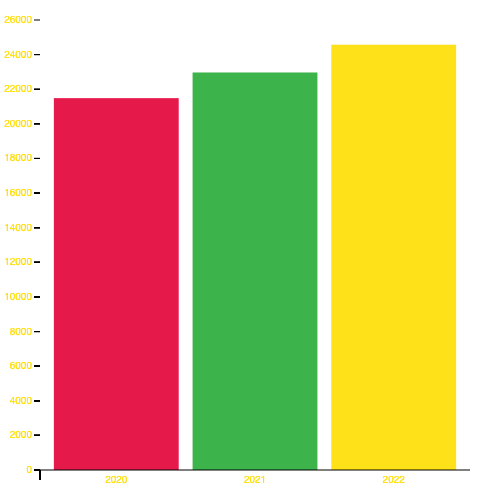

{
  ChartGenerator: {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "The bar chart illustrating the U.S. GDP over the past three years has been generated successfully. P"... 82 more characters,
          name: "ChartGenerator",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "The bar chart illustrating the U.S. GDP over the past three years has been generated successfully. P"... 82 more characters,
        name: "ChartGenerator",
        additional_kwargs: {}
      }
    ]
  }
}
----
{ supervisor: { next: "FINISH" } }
----


In [11]:
const streamResults = await graph.stream(
    {
        "messages": [
            new HumanMessage({content:"Generate a bar chart of the US gdp over the past 3 years."})
        ]
    },
    {recursionLimit: 150},
)
for await (const output of await streamResults) {
    if (!output?.__end__){
        console.log(output);
        console.log('----');
    }
}